# S04 T01: Transformació Registre Log amb Regular expressions
## Descripció

L'anàlisi de registres és una funció important per al control i l'alerta, el compliment de les polítiques de seguretat, l'auditoria i el compliment normatiu, la resposta a incidents de seguretat i fins i tot les investigacions forenses. En analitzar les dades de registre, les empreses poden identificar més fàcilment les possibles amenaces i altres problemes, trobar la causa arrel i iniciar una resposta ràpida per mitigar els riscos.
Nivell 1

L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han d'estandaritzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".

### - Exercici 1

Estandaritza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [115]:
import pandas as pd

# prepeare data to read csv
delimiter = r'(\S+)\s([0-9.]+|-)\s(.+)\s(.+)\s\[(\d+/\w+/\d{4}:\d+:\d+:\d+\s\+\d*)\]\s\"(\w{3,7}) (.*)\"\s(\d+|-)\s(\d+|-)\s\"(.+)\"\s\"(.+)\"\sVLOG=(.+)'
data_file = "Web_access_log-akumenius.com.txt"
column_names = ['ServerName', 'IP', 'undefined', 'User','Date','Request','Path','ErrorCode','PkgSize', 'RefererURL', 'Browser','VLOG' ] 

df = pd.read_csv(data_file,delimiter=delimiter,
    engine='python', 
    na_values="-",
    usecols = [*range(1, 13)],
    index_col=False,
    names=column_names, 
    dtype={"ServerName":str,"PkgSize":float,"ErrorCode":"Int64","Request":'category'}
)
df.drop(["undefined","VLOG"],axis=1,inplace=True)
df.Date=pd.to_datetime(df['Date'], format='%d/%b/%Y:%H:%M:%S %z',errors="coerce")
df.sample(5)

,ServerName,IP,User,Date,Request,Path,ErrorCode,PkgSize,RefererURL,Browser
66355,test.akumenius.com,217.125.71.222,NaN,2014-02-24 13:30:44+01:00,POST,/newdesign/destinos-get HTTP/1.1,200,NaN,http://test.akumenius.com/newdesign/hotel-list,Mozilla/5.0 (Windows NT 6.0; WOW64) AppleWebKi...
37373,www.akumenius.com,180.76.6.144,NaN,2014-02-23 22:36:03+01:00,GET,/destinos-baratos/destinos-caracteristicas/hot...,200,8233.0,NaN,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...
59218,www.akumenius.com,83.53.176.205,NaN,2014-02-24 12:40:07+01:00,GET,/modules/raton/views/themes/bcoos/images/key.p...,200,569.0,http://www.akumenius.com/hotel-list,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...
180347,www.akumenius.com,66.249.75.148,NaN,2014-02-26 23:11:00+01:00,GET,/destinos-caracteristicas/hoteles-baratos-en-S...,200,7869.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
161766,www.akumenius.com,183.60.212.156,NaN,2014-02-26 13:12:58+01:00,GET,/destinos-baratos/destinos-caracteristicas/hot...,200,20274.0,NaN,Mozilla/5.0 (compatible; EasouSpider; +http://...


## Nivell 2

### - Exercici 2

Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [116]:
df.info()
df.dropna(subset=['IP'],inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype                               
---  ------      --------------   -----                               
 0   ServerName  261831 non-null  object                              
 1   IP          261831 non-null  object                              
 2   User        27 non-null      object                              
 3   Date        261831 non-null  datetime64[ns, pytz.FixedOffset(60)]
 4   Request     261831 non-null  category                            
 5   Path        261831 non-null  object                              
 6   ErrorCode   261831 non-null  Int64                               
 7   PkgSize     219533 non-null  float64                             
 8   RefererURL  162326 non-null  object                              
 9   Browser     261654 non-null  object                              
dtypes: Int64(1), category(1), dateti

### - Exercici 3

Geolocalitza les IP's.

In [117]:
import IP2Location
from shapely.geometry import Point
class resolver:
    def __init__(self, ip):
        IP2LocObj = IP2Location.IP2Location()
        IP2LocObj.open("IP2LOCATION-LITE-DB11.BIN")
        self.result = IP2LocObj.get_all(ip)
    def get_city(self):
        return self.result.city
    def get_region(self):
        return self.result.region
    def get_country(self):
        return self.result.country_long
    def get_coordenadas(self):
        return Point(float(self.result.longitude),float(self.result.latitude))
    def get_json(self):
        return (self.result.str)

In [118]:
import geopandas as gpd

df['location']=df.apply(lambda row: resolver(row['IP']).get_coordenadas(),axis=1)

In [119]:
df.sample(10)

,ServerName,IP,User,Date,Request,Path,ErrorCode,PkgSize,RefererURL,Browser,location
183750,www.akumenius.com,79.168.72.6,NaN,2014-02-27 02:29:53+01:00,GET,/modules/raton/views/themes/bcoos/images/busca...,200,1926.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 5.1; rv:27.0) Gecko/20...,POINT (-9.133330000000001 38.716671)
224391,www.akumenius.com,79.147.132.1,NaN,2014-02-28 00:42:39+01:00,POST,/destinos-get HTTP/1.1,200,282.0,http://www.akumenius.com/,Mozilla/5.0 (Linux; U; Android 4.0.3; es-es; G...,POINT (-4.07402 40.715778)
90362,www.akumenius.com,84.77.167.235,NaN,2014-02-25 00:54:23+01:00,POST,/hotel-list-data/30862/EP/ESCAPADA%20WARNER%20...,200,7018.0,http://www.akumenius.com/hotel-list/30862/EP/E...,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0_4 like ...,POINT (-3.70256 40.4165)
127540,www.akumenius.com,109.107.105.181,NaN,2014-02-25 18:02:42+01:00,GET,/libraries/jqueryui/js/jquery.ui.core.min.js H...,200,4365.0,http://www.akumenius.com/?gclid=CMiG0PLg57wCFQ...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,POINT (-4.63805 37.586269)
259034,www.akumenius.com,66.249.76.216,NaN,2014-03-01 22:02:46+01:00,GET,/destinos-baratos/hoteles-en-Clifton_ESTADOS%2...,200,7243.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,POINT (-0.12574 51.50853)
214275,test.akumenius.com,80.28.221.123,NaN,2014-02-27 17:33:40+01:00,GET,/newdesign/libraries/anythingSlider/images/3r....,304,NaN,http://test.akumenius.com/newdesign/,Mozilla/5.0 (X11; U; Linux i686; ca; rv:1.9.2....,POINT (-0.48149 38.345169)
115243,www.akumenius.com,83.173.150.197,NaN,2014-02-25 16:03:09+01:00,GET,/modules/raton/views/themes/bcoos/css/escapada...,200,6218.0,http://www.akumenius.com/escapadas/escapada-go...,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0_4 like ...,POINT (-2.8476 42.57634)
139953,localhost,127.0.0.1,NaN,2014-02-25 21:33:09+01:00,OPTIONS,* HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),POINT (0 0)
132197,localhost,127.0.0.1,NaN,2014-02-25 18:49:02+01:00,OPTIONS,* HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),POINT (0 0)
39016,localhost,127.0.0.1,NaN,2014-02-23 23:15:59+01:00,OPTIONS,* HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),POINT (0 0)


## Nivell 3

### - Exercici 3

Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

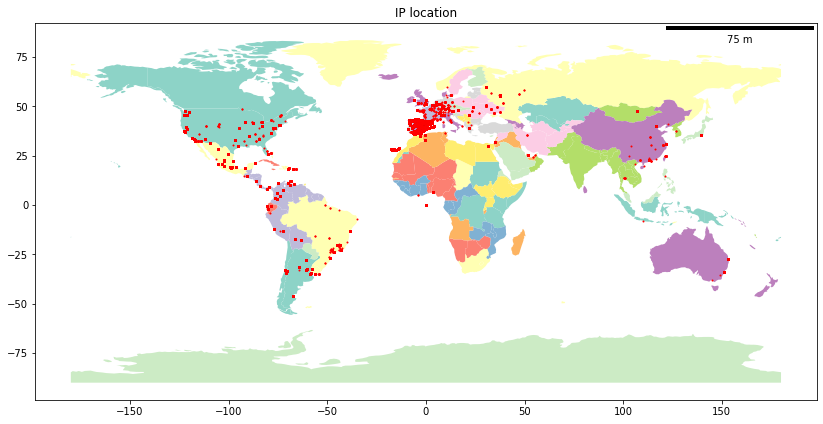

In [120]:
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from matplotlib_scalebar.scalebar import ScaleBar

gdf = GeoDataFrame(df, geometry=df.location)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax=world.plot(cmap='Set3', legend=True,figsize=(14, 14))
ax.add_artist(ScaleBar(1)) 
plt.title('IP location')
gdf.plot(ax=ax, marker='o', color='red', markersize=1);  



